The primary objective of this project is to leverage machine learning for predicting the revenues of ABB Electrification's business area. If the dataset proves suitable, an additional aim is to extend this methodology to ABB's industry counterparts.

To achieve these goals, we will conduct an in-depth analysis of the following datasets:
- Revenues CSV file for ABB and its peers (current as of Q3 2023)
- Macroeconomic indicators from the World Economic Forum (WEF) CSV file (reflecting data as of October 2023)

In [413]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from scipy.interpolate import interp1d
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

# Revenues file - Data modelling

In [414]:
# Loading the dataset with Company Revenue and Profitability
df = pd.read_csv("Financials v2 - Copy.csv", encoding='utf-8')

df

,Ticker,Company name,Segment,Segment Number,CIQ Formula,Currency,1/1/2010,4/1/2010,7/1/2010,10/1/2010,...,4/1/2021,7/1/2021,10/1/2021,1/1/2022,4/1/2022,7/1/2022,10/1/2022,1/1/2023,4/1/2023,7/1/2023
0,SWX:ABBN,ABB,Electrification,1,IQ_BUS_SEG_REV,USD,0.0,0.0,0.0,0.0,...,3406.0,3196.0,3445.0,3236.0,3414.0,3471.0,3663.0,3590.0,3735.0,3561.0
1,SWX:ABBN,ABB,Motion,2,IQ_BUS_SEG_REV,USD,0.0,0.0,0.0,0.0,...,1850.0,1673.0,1735.0,1572.0,1626.0,1702.0,1845.0,1940.0,1981.0,1947.0
2,SWX:ABBN,ABB,Process Automation,3,IQ_BUS_SEG_REV,USD,1735.0,1737.0,1859.0,2101.0,...,1540.0,1507.0,1805.0,1506.0,1529.0,1458.0,1551.0,1436.0,1553.0,1554.0
3,SWX:ABBN,ABB,Robotics & Discrete Automation,4,IQ_BUS_SEG_REV,USD,0.0,0.0,0.0,0.0,...,832.0,813.0,799.0,730.0,732.0,828.0,891.0,937.0,922.0,929.0
4,SWX:ABBN,ABB,"Corporate Costs, Intersegment Eliminations and...",5,IQ_BUS_SEG_REV,USD,-728.0,-716.0,-721.0,-834.0,...,-179.0,-161.0,-217.0,-79.0,-50.0,-53.0,-126.0,-44.0,-28.0,-23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,SHSE:601877,CHINT,Solar Energy Division,2,IQ_BUS_SEG_OPER_INC_ABS,CNY,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156,SHSE:601877,CHINT,Offset of Business Segment,3,IQ_BUS_SEG_OPER_INC_ABS,CNY,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157,SHSE:601877,CHINT,Low Voltage Division,1,IQ_BUS_SEG_OPER_INC_ABS,USD,29.3,0.0,38.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158,SHSE:601877,CHINT,Solar Energy Division,2,IQ_BUS_SEG_OPER_INC_ABS,USD,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [415]:
# Unpivot the DataFrame, change column types and change the 'CIQ Formula column' values
df = pd.melt(df, id_vars=['Ticker', 'Company name', 'Segment', 'Segment Number', 'CIQ Formula', 'Currency'], var_name='Date', value_name='Value')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
df['CIQ Formula'] = df['CIQ Formula'].replace({'IQ_BUS_SEG_REV': 'Revenue', 'IQ_BUS_SEG_OPER_INC_ABS': 'Profitability', 'IQ_BUS_SEG_EBITDA_ABS': 'Profitability'})
df = df.sort_values(by=['Ticker', 'Date'])

df
# Data types sanity-check
print(df.dtypes)

Ticker                    object
Company name              object
Segment                   object
Segment Number             int64
CIQ Formula               object
Currency                  object
Date              datetime64[ns]
Value                    float64
dtype: object


In [416]:
# Check how many missing values are in 'Value' column. Focus on Revenues.
zero_table = df[(df['Value'] == 0) & (df['CIQ Formula'] == 'Revenue')]
zero_table

,Ticker,Company name,Segment,Segment Number,CIQ Formula,Currency,Date,Value
3727,ENXTPA:RXL,REXEL,Wholesale - Electronics,1,Revenue,EUR,2015-10-01,0.0
3728,ENXTPA:RXL,REXEL,Wholesale - Electronics,1,Revenue,USD,2015-10-01,0.0
8687,ENXTPA:RXL,REXEL,Wholesale - Electronics,1,Revenue,EUR,2023-07-01,0.0
8688,ENXTPA:RXL,REXEL,Wholesale - Electronics,1,Revenue,USD,2023-07-01,0.0
17,ENXTPA:SU,Schneider Electric,Energy Management,1,Revenue,EUR,2010-01-01,0.0
...,...,...,...,...,...,...,...,...
5772,XTRA:SIE,Siemens,Industrial Businesses (IB) - Siemens Healthineers,4,Revenue,EUR,2019-01-01,0.0
5773,XTRA:SIE,Siemens,Industrial Businesses (IB) - Digital Industries,1,Revenue,USD,2019-01-01,0.0
5774,XTRA:SIE,Siemens,Industrial Businesses (IB) - Smart Infrastructure,2,Revenue,USD,2019-01-01,0.0
5775,XTRA:SIE,Siemens,Industrial Businesses (IB) - Mobility,3,Revenue,USD,2019-01-01,0.0


Now we have confirmed that each column has been assigned the correct data type, but we've identified numerous missing values that require attention. Imputing the mean value may not be feasible due to the high prevalence of missing data. Let's explore whether Linear Regression would be a suitable approach.

In [417]:
# Extract the year and month from the 'Date' column
df['YearMonth'] = df['Date'].dt.to_period('M')

# Map Year-Month to a numerical representation
df['YearMonthNumeric'] = df['YearMonth'].apply(lambda x: x.year * 12 + x.month)

# Select rows with 'Value' == 0 and 'Value' != 0
df_missing = df[df['Value'] == 0]
df_not_missing = df[df['Value'] != 0].copy()  # Make a copy to avoid the SettingWithCopyWarning

# Create a new column combining 'Ticker', 'Currency', 'CIQ Formula', and 'Segment' for unique combinations
df_not_missing['UniqueCombination'] = (
    df_not_missing['Ticker'] + '_' + df_not_missing['Currency'] + '_' +
    df_not_missing['CIQ Formula'] + '_' + df_not_missing['Segment']
)

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame()

# Iterate over unique combinations
for combination, group in df_not_missing.groupby('UniqueCombination'):
    # Check if there are any samples for training
    if len(group) > 0:
        # Prepare data for regression
        X_train = group[['YearMonthNumeric']].values.reshape(-1, 1)
        y_train = group['Value'].values

        # Filter the missing values based on the current combination
        missing_filter = (
            (df_missing['Ticker'] + '_' + df_missing['Currency'] + '_' +
             df_missing['CIQ Formula'] + '_' + df_missing['Segment']) == combination
        )
        indices = df_missing.loc[missing_filter].index

        # Check if there are any missing values for the current combination
        if len(indices) > 0:
            # Initialize the linear regression model
            model = LinearRegression()

            # Train the model
            model.fit(X_train, y_train)

            # Predict missing values
            predicted_values = model.predict(df_missing.loc[missing_filter, ['YearMonthNumeric']].values.reshape(-1, 1))

            # Update DataFrame with predicted values using indices
            df.loc[indices, 'Value'] = predicted_values
    else:
        print(f"Not enough samples for {combination}, skipping...")

df

,Ticker,Company name,Segment,Segment Number,CIQ Formula,Currency,Date,Value,YearMonth,YearMonthNumeric
5,ENXTPA:LR,Legrand,Electric Equipment,1,Revenue,EUR,2010-01-01,911.7,2010-01,24121
6,ENXTPA:LR,Legrand,Electric Equipment,1,Revenue,USD,2010-01-01,1232.8,2010-01,24121
85,ENXTPA:LR,Legrand,Electric Equipment,1,Profitability,EUR,2010-01-01,0.0,2010-01,24121
86,ENXTPA:LR,Legrand,Electric Equipment,1,Profitability,USD,2010-01-01,0.0,2010-01,24121
165,ENXTPA:LR,Legrand,Electric Equipment,1,Revenue,EUR,2010-04-01,998.4,2010-04,24124
...,...,...,...,...,...,...,...,...,...,...
8732,XTRA:SIE,Siemens,Industrial Businesses (IB) - Siemens Healthineers,4,Profitability,EUR,2023-07-01,856.0,2023-07,24283
8733,XTRA:SIE,Siemens,Industrial Businesses (IB) - Digital Industries,1,Profitability,USD,2023-07-01,1390.8,2023-07,24283
8734,XTRA:SIE,Siemens,Industrial Businesses (IB) - Smart Infrastructure,2,Profitability,USD,2023-07-01,843.6,2023-07,24283
8735,XTRA:SIE,Siemens,Industrial Businesses (IB) - Mobility,3,Profitability,USD,2023-07-01,219.1,2023-07,24283


In [418]:
# Check if there are still some missing data in dataset. Lets use ABB, Electrification example
abb_data = df[(df['Company name'] == 'ABB') & (df['CIQ Formula'] == 'Revenue') & (df['Segment'] == 'Electrification')]
abb_data

,Ticker,Company name,Segment,Segment Number,CIQ Formula,Currency,Date,Value,YearMonth,YearMonthNumeric
0,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2010-01-01,1463.604129,2010-01,24121
160,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2010-04-01,1504.187562,2010-04,24124
320,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2010-07-01,1544.770996,2010-07,24127
480,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2010-10-01,1585.354429,2010-10,24130
640,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2011-01-01,1625.937862,2011-01,24133
800,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2011-04-01,1666.521295,2011-04,24136
960,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2011-07-01,1707.104729,2011-07,24139
1120,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2011-10-01,1747.688162,2011-10,24142
1280,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2012-01-01,1788.271595,2012-01,24145
1440,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2012-04-01,1828.855028,2012-04,24148


# Revenues file - Drawing a chart for ABB Electrification

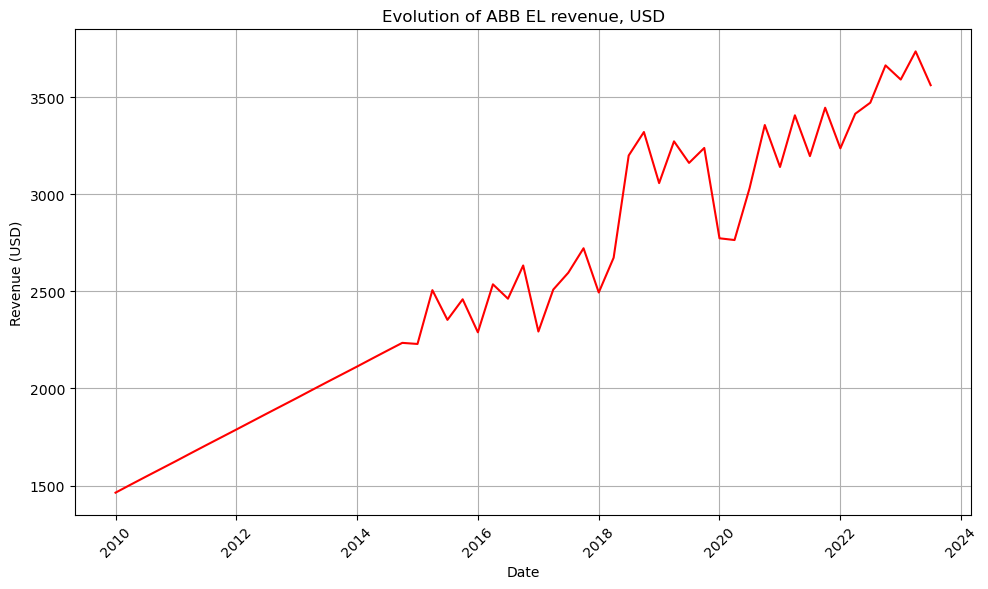

In [419]:
# Create the plot chart
abb_data = abb_data.sort_values(by='Date')
plt.figure(figsize=(10, 6))
plt.plot(abb_data['Date'], abb_data['Value'], linestyle='-', color='r')
plt.title('Evolution of ABB EL revenue, USD')
plt.xlabel('Date')
plt.ylabel('Revenue (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

Linear regression might be not the best solution here.
For the period from 2010 to 2015 the line it "too flat". Lets see it similar situtation is occuring in other company - for example Siemens.

In [420]:
# Filter for Siemens, Smart Infrastructure
siemens_data = df[(df['Company name'] == 'Siemens') & (df['CIQ Formula'] == 'Revenue') & (df['Segment'] == 'Industrial Businesses (IB) - Smart Infrastructure') & (df['Currency'] == 'USD')]
siemens_data

,Ticker,Company name,Segment,Segment Number,CIQ Formula,Currency,Date,Value,YearMonth,YearMonthNumeric
14,XTRA:SIE,Siemens,Industrial Businesses (IB) - Smart Infrastructure,2,Revenue,USD,2010-01-01,1748.507478,2010-01,24121
174,XTRA:SIE,Siemens,Industrial Businesses (IB) - Smart Infrastructure,2,Revenue,USD,2010-04-01,1811.993409,2010-04,24124
334,XTRA:SIE,Siemens,Industrial Businesses (IB) - Smart Infrastructure,2,Revenue,USD,2010-07-01,1875.479341,2010-07,24127
494,XTRA:SIE,Siemens,Industrial Businesses (IB) - Smart Infrastructure,2,Revenue,USD,2010-10-01,1938.965272,2010-10,24130
654,XTRA:SIE,Siemens,Industrial Businesses (IB) - Smart Infrastructure,2,Revenue,USD,2011-01-01,2002.451204,2011-01,24133
814,XTRA:SIE,Siemens,Industrial Businesses (IB) - Smart Infrastructure,2,Revenue,USD,2011-04-01,2065.937136,2011-04,24136
974,XTRA:SIE,Siemens,Industrial Businesses (IB) - Smart Infrastructure,2,Revenue,USD,2011-07-01,2129.423067,2011-07,24139
1134,XTRA:SIE,Siemens,Industrial Businesses (IB) - Smart Infrastructure,2,Revenue,USD,2011-10-01,2192.908999,2011-10,24142
1294,XTRA:SIE,Siemens,Industrial Businesses (IB) - Smart Infrastructure,2,Revenue,USD,2012-01-01,2256.394930,2012-01,24145
1454,XTRA:SIE,Siemens,Industrial Businesses (IB) - Smart Infrastructure,2,Revenue,USD,2012-04-01,2319.880862,2012-04,24148


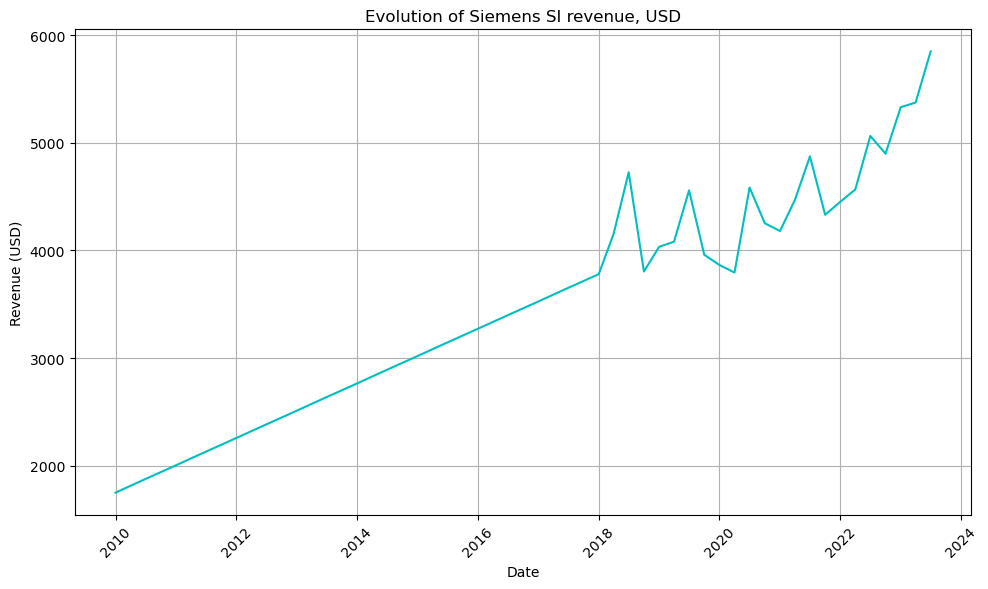

In [421]:
# Create the plot
siemens_data = siemens_data.sort_values(by='Date')
plt.figure(figsize=(10, 6))
plt.plot(siemens_data['Date'], siemens_data['Value'], linestyle='-', color='c')
plt.title('Evolution of Siemens SI revenue, USD')
plt.xlabel('Date')
plt.ylabel('Revenue (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

The situation is even worse. Here, data is missing until 2018.

# Revenues file - Checking other companies

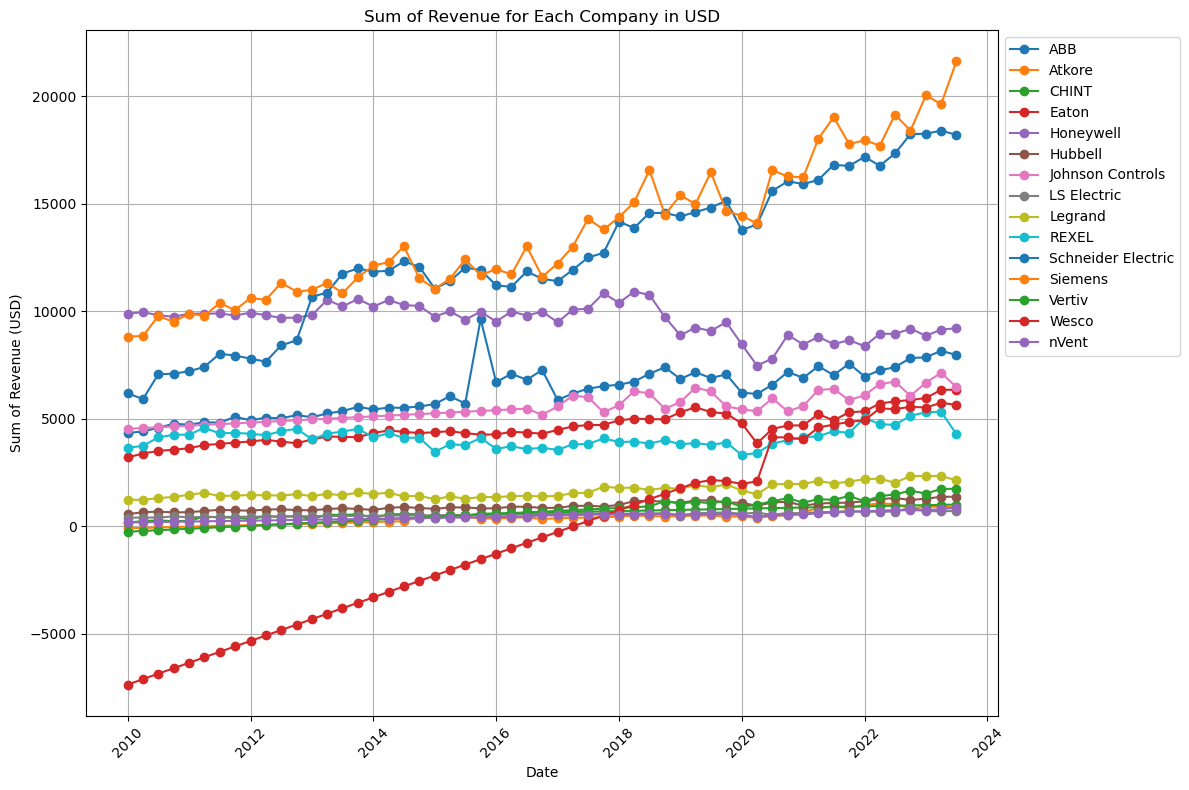

In [422]:
# Group by'Company Name' i 'Date' and summarize Revenues in USD
revenue_data = df[df['CIQ Formula'] == 'Revenue']
summed_data = revenue_data.groupby(['Company name', 'Date', 'Currency'], as_index=False)['Value'].sum()
summed_data_usd = summed_data[summed_data['Currency'] == 'USD']

# Create the plot
plt.figure(figsize=(12, 8))

# Go through all companies
for company in summed_data_usd['Company name'].unique():
    company_data = summed_data_usd[summed_data_usd['Company name'] == company]
    plt.plot(company_data['Date'], company_data['Value'], label=company, marker='o', linestyle='-')

plt.title('Sum of Revenue for Each Company in USD')
plt.xlabel('Date')
plt.ylabel('Sum of Revenue (USD)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')  # Umieść legendę poza wykresem
plt.grid(True)
plt.tight_layout()

plt.show()

In summary, it's crucial to note that a comprehensive analysis is hindered by the absence of reliable pre-2018 data for certain companies, such as Wesco and Siemens. Therefore, to align with the primary objective of developing a ML model tailored to ABB Electrification, our focus will be exclusively on that specific dataset.

# Revenues file - Applying 2028 Revenues prediction for ABB, Electrification

Let's see how it would look like with pre 2015 data incorporated.

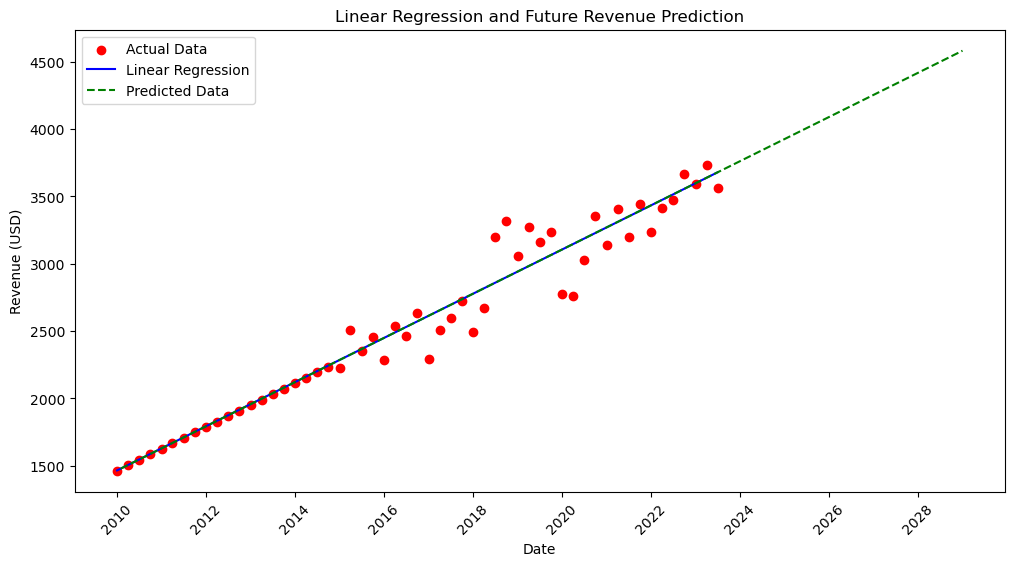

Predicted Revenue for 2028-12-31: 4581.94 USD
Mean Absolute Error (MAE) on training data: 98.32
Mean Squared Error (MSE) on training data: 21075.06
Root Mean Squared Error (RMSE) on training data: 145.17
R-squared (R²) on training data: 0.9534


In [423]:
# Prepare the Revenue data for ABB, Electrification
revenue_data = df[(df['CIQ Formula'] == 'Revenue') & (df['Segment'] == 'Electrification')]
summed_data = revenue_data.groupby(['Company name', 'Date', 'Currency'], as_index=False)['Value'].sum()
abb_data = summed_data[summed_data['Company name'] == 'ABB']
end_date = '2028-12-31'

def linear_regression_and_metrics(data, end_date='2028-12-31', test_size=0.2, random_state=42):
    # Linear regression model
    X = (data['Date'] - data['Date'].min()).dt.days.values.reshape(-1, 1)
    y = data['Value']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train the model on the training set
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict revenues for the entire dataset
    y_pred = model.predict(X)

    # Generate dates up to the specified end date
    future_dates = pd.date_range(start=data['Date'].min(), end=end_date, freq='M')
    future_days = (future_dates - data['Date'].min()).days.values.reshape(-1, 1)

    # Predict revenues for future dates
    future_predictions = model.predict(future_days)

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.scatter(data['Date'], data['Value'], label='Actual Data', color='red')
    plt.plot(data['Date'], y_pred, label='Linear Regression', color='blue')
    plt.plot(future_dates, future_predictions, label='Predicted Data', linestyle='dashed', color='green')
    plt.xlabel('Date')
    plt.ylabel('Revenue (USD)')
    plt.title('Linear Regression and Future Revenue Prediction')
    plt.legend()
    plt.xticks(rotation=45)

    plt.show()

    # Calculate performance metrics on the training set
    y_pred_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = sqrt(mse_train)
    r2_train = r2_score(y_train, y_pred_train)

    # Print the results
    end_date_prediction = model.predict([[ (pd.to_datetime(end_date) - data['Date'].min()).days ]])
    print(f'Predicted Revenue for {end_date}: {end_date_prediction[0]:.2f} USD')
    print(f'Mean Absolute Error (MAE) on training data: {mae_train:.2f}')
    print(f'Mean Squared Error (MSE) on training data: {mse_train:.2f}')
    print(f'Root Mean Squared Error (RMSE) on training data: {rmse_train:.2f}')
    print(f'R-squared (R²) on training data: {r2_train:.4f}')

# Example usage
linear_regression_and_metrics(abb_data, end_date, test_size=0.2, random_state=42)

Let's now apply the same code, but for the dataset starting from 2015.

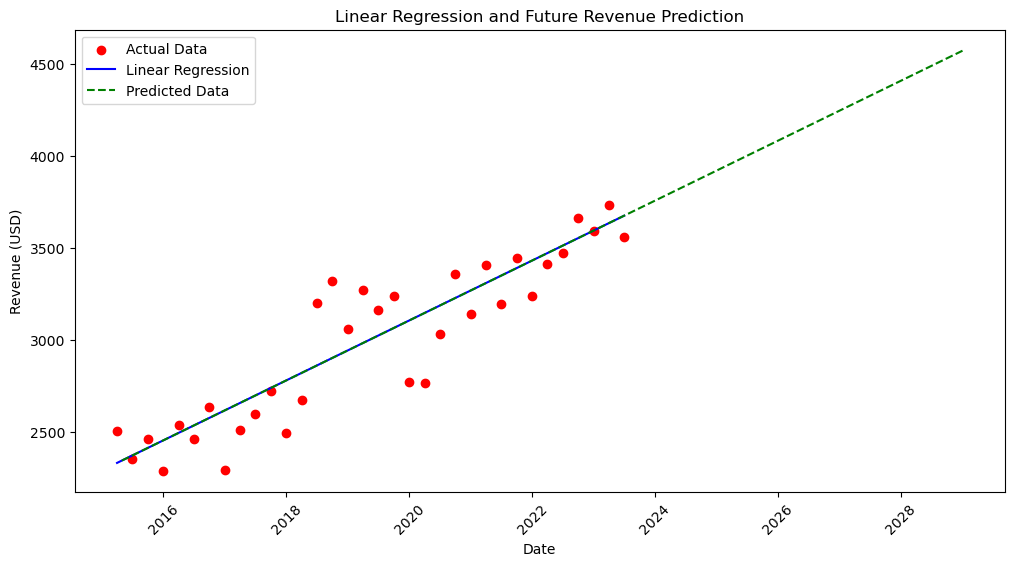

Predicted Revenue for 2028-12-31: 4571.01 USD
Mean Absolute Error (MAE) on training data: 149.22
Mean Squared Error (MSE) on training data: 35352.34
Root Mean Squared Error (RMSE) on training data: 188.02
R-squared (R²) on training data: 0.8339


In [424]:
# Select only data related to Revenue, Electrification and starting from 2015
abb_data_new = abb_data[abb_data['Date'] > '2015-01-01']

# Use previously defined formula
linear_regression_and_metrics(abb_data_new, end_date, test_size=0.2, random_state=42)

Now, let's try SVM model.

Predicted Revenue for 2028-12-31: 4547.40 USD
Mean Absolute Error (MAE) on training data: 93.36
Mean Squared Error (MSE) on training data: 21227.40
Root Mean Squared Error (RMSE) on training data: 145.70
R-squared (R²) on training data: 0.9513


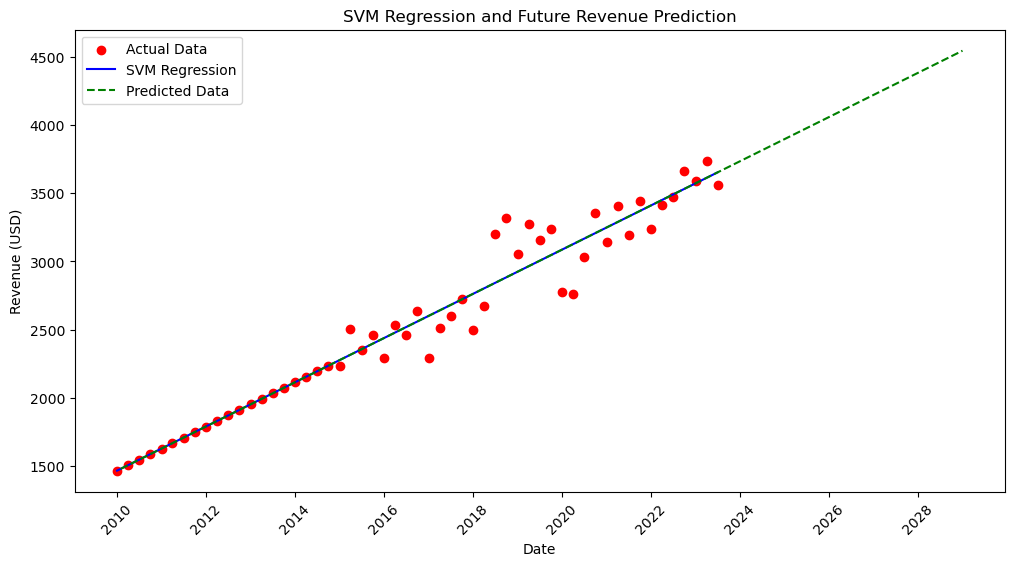

In [425]:
def svm_regression_model(data, end_date):
    # Support Vector Machine for regression model
    X = (data['Date'] - data['Date'].min()).dt.days.values.reshape(-1, 1)
    y = data['Value']

    # Train a Support Vector Machine for regression model
    svm_model = SVR(kernel='linear')  # You can choose other kernels like 'rbf', 'poly', etc.
    svm_model.fit(X, y)

    # Generate dates up to the specified end date
    future_dates = pd.date_range(start=data['Date'].min(), end=end_date, freq='M')
    future_days = (future_dates - data['Date'].min()).days.values.reshape(-1, 1)

    # Predict revenues for future dates
    future_predictions = svm_model.predict(future_days)

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.scatter(data['Date'], data['Value'], label='Actual Data', color='red')
    plt.plot(data['Date'], svm_model.predict(X), label='SVM Regression', color='blue')
    plt.plot(future_dates, future_predictions, label='Predicted Data', linestyle='dashed', color='green')
    plt.xlabel('Date')
    plt.ylabel('Revenue (USD)')
    plt.title('SVM Regression and Future Revenue Prediction')
    plt.legend()
    plt.xticks(rotation=45)

    # Print predicted revenues for the end date
    end_date_prediction = svm_model.predict([[ (pd.to_datetime(end_date) - data['Date'].min()).days ]])
    print(f'Predicted Revenue for {end_date}: {end_date_prediction[0]:.2f} USD')

    # Performance Metrics
    y_pred_train = svm_model.predict(X)
    mae_train = mean_absolute_error(y, y_pred_train)
    mse_train = mean_squared_error(y, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y, y_pred_train)

    print(f'Mean Absolute Error (MAE) on training data: {mae_train:.2f}')
    print(f'Mean Squared Error (MSE) on training data: {mse_train:.2f}')
    print(f'Root Mean Squared Error (RMSE) on training data: {rmse_train:.2f}')
    print(f'R-squared (R²) on training data: {r2_train:.4f}')

    plt.show()

# Call the function
svm_regression_model(abb_data, end_date)

Let's use Gradieng Boosting Regression now.

Mean Absolute Error (MAE) on test data: 108.34
Mean Squared Error (MSE) on test data: 19162.02
Root Mean Squared Error (RMSE) on test data: 138.43
R-squared (R²) on test data: 0.9484
Predicted Revenue for 2028-12-31: 3568.27 USD


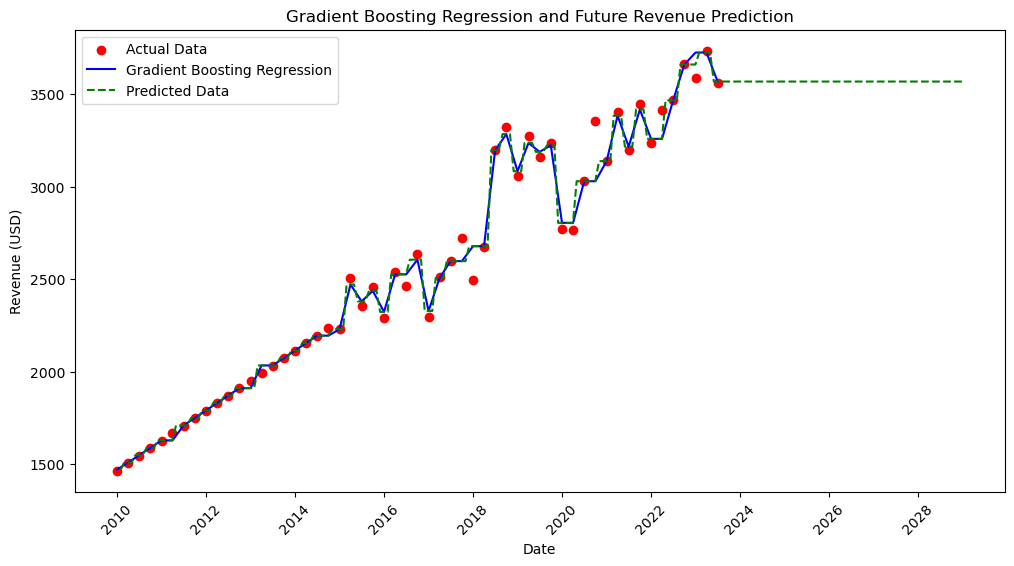

In [426]:
def gradient_boosting_model(data, end_date):
    # Feature engineering: Use the number of days since the minimum date
    X = (data['Date'] - data['Date'].min()).dt.days.values.reshape(-1, 1)
    y = data['Value']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Gradient Boosting Regressor model
    gb_model = GradientBoostingRegressor()
    gb_model.fit(X_train, y_train)

    # Predictions on the test set
    y_pred_test = gb_model.predict(X_test)

    # Performance Metrics on the test set
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)

    print(f'Mean Absolute Error (MAE) on test data: {mae_test:.2f}')
    print(f'Mean Squared Error (MSE) on test data: {mse_test:.2f}')
    print(f'Root Mean Squared Error (RMSE) on test data: {rmse_test:.2f}')
    print(f'R-squared (R²) on test data: {r2_test:.4f}')

    # Generate dates up to the specified end date
    future_dates = pd.date_range(start=data['Date'].min(), end=end_date, freq='M')
    future_days = (future_dates - data['Date'].min()).days.values.reshape(-1, 1)

    # Predict revenues for future dates
    future_predictions = gb_model.predict(future_days)
        
    # Print predicted revenues for the end date
    end_date_prediction = gb_model.predict([[ (pd.to_datetime(end_date) - data['Date'].min()).days ]])
    print(f'Predicted Revenue for {end_date}: {end_date_prediction[0]:.2f} USD')

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.scatter(data['Date'], data['Value'], label='Actual Data', color='red')
    plt.plot(data['Date'], gb_model.predict(X), label='Gradient Boosting Regression', color='blue')
    plt.plot(future_dates, future_predictions, label='Predicted Data', linestyle='dashed', color='green')
    plt.xlabel('Date')
    plt.ylabel('Revenue (USD)')
    plt.title('Gradient Boosting Regression and Future Revenue Prediction')
    plt.legend()
    plt.xticks(rotation=45)

    plt.show()

# Call the function
gradient_boosting_model(abb_data, end_date)

Gradient Boosting Regression Predicted Revenue is flat. The reason might be the bad imput data quality.

Linear Regression has a slightly lower MAE, indicating better accuracy in predicting revenue values.
SVM has a slightly lower MSE and RMSE, indicating lower errors in predicting revenue values.

We will proceed with SVM then.

In [427]:
# Select only data related to Revenue and ABB Electrification
electrification_data = df[(df['CIQ Formula'] == 'Revenue') & (df['Company name'] == 'ABB') & (df['Segment'] == 'Electrification')]

# Select data for linear regression model
X = (electrification_data['Date'] - electrification_data['Date'].min()).dt.days.values.reshape(-1, 1)
y = electrification_data['Value']

# Linear regression model
model = SVR(kernel='linear')
model.fit(X, y)
future_dates = pd.date_range(start=electrification_data['Date'].min(), end='2028-12-31', freq='Q')
future_days = (future_dates - electrification_data['Date'].min()).days.values.reshape(-1, 1)

# Predict revenues for future dates and create a DataFrame
future_predictions = model.predict(future_days)
predictions_df = pd.DataFrame({'Date': future_dates, 'Comapny name': 'ABB', 'Segment': 'Electrification', 'Measure': 'Revenue', 'Value': future_predictions})

predictions_df

,Date,Comapny name,Segment,Measure,Value
0,2010-03-31,ABB,Electrification,Revenue,1503.643218
1,2010-06-30,ABB,Electrification,Revenue,1544.078537
2,2010-09-30,ABB,Electrification,Revenue,1584.958199
3,2010-12-31,ABB,Electrification,Revenue,1625.837862
4,2011-03-31,ABB,Electrification,Revenue,1665.828836
...,...,...,...,...,...
71,2027-12-31,ABB,Electrification,Revenue,4384.770749
72,2028-03-31,ABB,Electrification,Revenue,4425.206067
73,2028-06-30,ABB,Electrification,Revenue,4465.641386
74,2028-09-30,ABB,Electrification,Revenue,4506.521049


In [428]:
# Data type sanity-check
predictions_df.dtypes

Date            datetime64[ns]
Comapny name            object
Segment                 object
Measure                 object
Value                  float64
dtype: object

# Macroeconomics file - Data modelling

In [429]:
macro = pd.read_csv("WEOOct2023all.csv")
macro

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,288.87","1,021.60",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,"See notes for: Gross domestic product, consta...",NaN,...,-2.351,-20.737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,547.29","1,232.86",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,20.136,14.941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,81.007,67.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8621,698,ZWE,NGDP_FY,Zimbabwe,Gross domestic product corresponding to fiscal...,Gross domestic product corresponding to fiscal...,National currency,Billions,Source: Ministry of Finance or Treasury Latest...,NaN,...,"1,380.14","3,187.63","12,292.67","111,864.93","474,084.10","1,102,309.64","2,089,955.60","3,126,416.82","4,128,929.25",2021.0
8622,698,ZWE,BCA,Zimbabwe,Current account balance,Current account is all transactions other than...,U.S. dollars,Billions,Source: Reserve Bank of Zimbabwe and Ministry ...,-0.301,...,0.678,0.348,0.321,0.28,-0.317,-0.411,-0.466,-0.512,-0.55,2022.0
8623,698,ZWE,BCA_NGDPD,Zimbabwe,Current account balance,Current account is all transactions other than...,Percent of GDP,NaN,"See notes for: Gross domestic product, curren...",NaN,...,2.521,0.968,1.019,0.863,-0.673,-0.827,-0.922,-1.081,-1.12,2022.0
8624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [430]:
# Unpivot the DataFrame, delete all unnecessary columns and all NaN's. Leave dates starting from 2010
macro = macro.drop(['WEO Country Code', 'WEO Subject Code', 'Subject Notes', 'Country/Series-specific Notes'], axis=1)
macro = pd.melt(macro, id_vars=['ISO', 'Country', 'Subject Descriptor', 'Units', 'Scale'], var_name='Date', value_name='Value')
macro = macro.dropna(how='all')
macro = macro.dropna(subset=['Value'])
macro = macro[macro['Date'] != 'Estimates Start After']
macro = macro[macro['Date'] >= '2010']

macro

,ISO,Country,Subject Descriptor,Units,Scale,Date,Value
258780,AFG,Afghanistan,"Gross domestic product, constant prices",National currency,Billions,2010,899.956
258781,AFG,Afghanistan,"Gross domestic product, constant prices",Percent change,NaN,2010,8.438
258782,AFG,Afghanistan,"Gross domestic product, current prices",National currency,Billions,2010,711.759
258783,AFG,Afghanistan,"Gross domestic product, current prices",U.S. dollars,Billions,2010,15.325
258784,AFG,Afghanistan,"Gross domestic product, current prices",Purchasing power parity; international dollars,Billions,2010,46.309
...,...,...,...,...,...,...,...
422667,ZWE,Zimbabwe,General government gross debt,National currency,Billions,2028,"1,763,004.39"
422668,ZWE,Zimbabwe,General government gross debt,Percent of GDP,NaN,2028,42.699
422669,ZWE,Zimbabwe,Gross domestic product corresponding to fiscal...,National currency,Billions,2028,"4,128,929.25"
422670,ZWE,Zimbabwe,Current account balance,U.S. dollars,Billions,2028,-0.55


In [431]:
# Data type sanity-check
print(macro.dtypes)

ISO                   object
Country               object
Subject Descriptor    object
Units                 object
Scale                 object
Date                  object
Value                 object
dtype: object


In [432]:
# Fix formats and sort by ISO and Date
macro['Date'] = pd.to_datetime(macro['Date'], errors='coerce')
macro['Value'] = pd.to_numeric(macro['Value'], errors='coerce')
macro = macro.sort_values(by=['ISO', 'Date'])

macro

,ISO,Country,Subject Descriptor,Units,Scale,Date,Value
259132,ABW,Aruba,"Gross domestic product, constant prices",National currency,Billions,2010-01-01,4.485
259133,ABW,Aruba,"Gross domestic product, constant prices",Percent change,NaN,2010-01-01,-2.733
259134,ABW,Aruba,"Gross domestic product, current prices",National currency,Billions,2010-01-01,4.392
259135,ABW,Aruba,"Gross domestic product, current prices",U.S. dollars,Billions,2010-01-01,2.454
259136,ABW,Aruba,"Gross domestic product, current prices",Purchasing power parity; international dollars,Billions,2010-01-01,3.434
...,...,...,...,...,...,...,...
422667,ZWE,Zimbabwe,General government gross debt,National currency,Billions,2028-01-01,NaN
422668,ZWE,Zimbabwe,General government gross debt,Percent of GDP,NaN,2028-01-01,42.699
422669,ZWE,Zimbabwe,Gross domestic product corresponding to fiscal...,National currency,Billions,2028-01-01,NaN
422670,ZWE,Zimbabwe,Current account balance,U.S. dollars,Billions,2028-01-01,-0.550


In [434]:
# Investigate Units
unique_sd = macro['Subject Descriptor'].unique()
unique_sd

array(['Gross domestic product, constant prices',
       'Gross domestic product, current prices',
       'Gross domestic product, deflator',
       'Gross domestic product per capita, constant prices',
       'Gross domestic product per capita, current prices',
       'Gross domestic product based on purchasing-power-parity (PPP) share of world total',
       'Implied PPP conversion rate', 'Gross national savings',
       'Inflation, average consumer prices',
       'Inflation, end of period consumer prices', 'Unemployment rate',
       'Population', 'General government revenue',
       'General government total expenditure',
       'General government net lending/borrowing',
       'General government primary net lending/borrowing',
       'General government gross debt',
       'Gross domestic product corresponding to fiscal year, current prices',
       'Current account balance', 'Total investment',
       'Volume of imports of goods and services',
       'Volume of Imports of good

In [400]:
# Remove unnecessary Units
values_to_remove = ['National currency', 'Percent change','Purchasing power parity; international dollars', 'Index',
       'Purchasing power parity; 2017 international dollar', 'Percent',
       'National currency per current international dollar',
       'Percent of GDP', 'Percent of total labor force', 'Percent of potential GDP']
macro = macro[~macro['Subject Descriptor'].isin(values_to_remove)]
macro = macro.dropna(subset=['Value'])

macro

,ISO,Country,Subject Descriptor,Units,Scale,Date,Value
259135,ABW,Aruba,"Gross domestic product, current prices",U.S. dollars,Billions,2010-01-01,2.454
259158,ABW,Aruba,Population,Persons,Millions,2010-01-01,0.102
259174,ABW,Aruba,Current account balance,U.S. dollars,Billions,2010-01-01,-0.460
267761,ABW,Aruba,"Gross domestic product, current prices",U.S. dollars,Billions,2011-01-01,2.638
267784,ABW,Aruba,Population,Persons,Millions,2011-01-01,0.103
...,...,...,...,...,...,...,...
414028,ZWE,Zimbabwe,Population,Persons,Millions,2027-01-01,17.407
414044,ZWE,Zimbabwe,Current account balance,U.S. dollars,Billions,2027-01-01,-0.512
422631,ZWE,Zimbabwe,"Gross domestic product, current prices",U.S. dollars,Billions,2028-01-01,49.153
422654,ZWE,Zimbabwe,Population,Persons,Millions,2028-01-01,17.729


In [401]:
#Delete more unnecessary columns
macro = macro.drop(['ISO', 'Units', 'Scale'], axis=1)
macro

,Country,Subject Descriptor,Date,Value
259135,Aruba,"Gross domestic product, current prices",2010-01-01,2.454
259158,Aruba,Population,2010-01-01,0.102
259174,Aruba,Current account balance,2010-01-01,-0.460
267761,Aruba,"Gross domestic product, current prices",2011-01-01,2.638
267784,Aruba,Population,2011-01-01,0.103
...,...,...,...,...
414028,Zimbabwe,Population,2027-01-01,17.407
414044,Zimbabwe,Current account balance,2027-01-01,-0.512
422631,Zimbabwe,"Gross domestic product, current prices",2028-01-01,49.153
422654,Zimbabwe,Population,2028-01-01,17.729


Now the dataset with macroeconomic indicators contains only convinient stuff. Next step is to pivot measures.

In [402]:
# Pivot table and reset index
pivot_macro = macro.pivot(index=['Country', 'Date'], columns='Subject Descriptor', values='Value').reset_index()
pivot_macro

Subject Descriptor,Country,Date,Current account balance,Employment,"Gross domestic product per capita, current prices","Gross domestic product, current prices",Population
0,Afghanistan,2010-01-01,4.510,NaN,631.490,15.325,24.269
1,Afghanistan,2011-01-01,4.754,NaN,714.700,17.890,25.031
2,Afghanistan,2012-01-01,2.205,NaN,784.611,20.293,25.864
3,Afghanistan,2013-01-01,0.291,NaN,754.402,20.170,26.736
4,Afghanistan,2014-01-01,1.350,NaN,746.922,20.616,27.601
...,...,...,...,...,...,...,...
3668,Zimbabwe,2024-01-01,-0.317,NaN,NaN,47.078,16.481
3669,Zimbabwe,2025-01-01,-0.411,NaN,NaN,49.734,16.790
3670,Zimbabwe,2026-01-01,-0.466,NaN,NaN,50.479,17.095
3671,Zimbabwe,2027-01-01,-0.512,NaN,NaN,47.398,17.407


Column "Employment" seems to be empty - let's drop it too.

In [403]:
# Delete 'Employment' column
pivot_macro = pivot_macro.drop(['Employment'], axis=1)
pivot_macro

Subject Descriptor,Country,Date,Current account balance,"Gross domestic product per capita, current prices","Gross domestic product, current prices",Population
0,Afghanistan,2010-01-01,4.510,631.490,15.325,24.269
1,Afghanistan,2011-01-01,4.754,714.700,17.890,25.031
2,Afghanistan,2012-01-01,2.205,784.611,20.293,25.864
3,Afghanistan,2013-01-01,0.291,754.402,20.170,26.736
4,Afghanistan,2014-01-01,1.350,746.922,20.616,27.601
...,...,...,...,...,...,...
3668,Zimbabwe,2024-01-01,-0.317,NaN,47.078,16.481
3669,Zimbabwe,2025-01-01,-0.411,NaN,49.734,16.790
3670,Zimbabwe,2026-01-01,-0.466,NaN,50.479,17.095
3671,Zimbabwe,2027-01-01,-0.512,NaN,47.398,17.407


This dataset is almost ready to be merged with the first one. There are only 2 additional columns missing. Since we are focuing on ABB Electrification this time, I will add these values as strings for the time being.

In [404]:
# Add two columns
pivot_macro['Comapny name'] = 'ABB'
pivot_macro['Segment'] = 'Electrification'
pivot_macro

Subject Descriptor,Country,Date,Current account balance,"Gross domestic product per capita, current prices","Gross domestic product, current prices",Population,Comapny name,Segment
0,Afghanistan,2010-01-01,4.510,631.490,15.325,24.269,ABB,Electrification
1,Afghanistan,2011-01-01,4.754,714.700,17.890,25.031,ABB,Electrification
2,Afghanistan,2012-01-01,2.205,784.611,20.293,25.864,ABB,Electrification
3,Afghanistan,2013-01-01,0.291,754.402,20.170,26.736,ABB,Electrification
4,Afghanistan,2014-01-01,1.350,746.922,20.616,27.601,ABB,Electrification
...,...,...,...,...,...,...,...,...
3668,Zimbabwe,2024-01-01,-0.317,NaN,47.078,16.481,ABB,Electrification
3669,Zimbabwe,2025-01-01,-0.411,NaN,49.734,16.790,ABB,Electrification
3670,Zimbabwe,2026-01-01,-0.466,NaN,50.479,17.095,ABB,Electrification
3671,Zimbabwe,2027-01-01,-0.512,NaN,47.398,17.407,ABB,Electrification


Let's take another look at database with ABB EL revenues to see if we can merge it with new Macro dataset

In [405]:
predictions_df

,Date,Comapny name,Segment,Measure,Value
0,2010-03-31,ABB,Electrification,Revenue,1503.643218
1,2010-06-30,ABB,Electrification,Revenue,1544.078537
2,2010-09-30,ABB,Electrification,Revenue,1584.958199
3,2010-12-31,ABB,Electrification,Revenue,1625.837862
4,2011-03-31,ABB,Electrification,Revenue,1665.828836
...,...,...,...,...,...
71,2027-12-31,ABB,Electrification,Revenue,4384.770749
72,2028-03-31,ABB,Electrification,Revenue,4425.206067
73,2028-06-30,ABB,Electrification,Revenue,4465.641386
74,2028-09-30,ABB,Electrification,Revenue,4506.521049


Once we try to merge these two columns, there might be an issue with Date column. Macro database is showing full year data, while predictions df is quarterly based. Let's change this column to show full year in both cases.

In [406]:
# Change 'Date' column to show year only
pivot_macro['Date'] = pivot_macro['Date'].dt.year
pivot_macro

Subject Descriptor,Country,Date,Current account balance,"Gross domestic product per capita, current prices","Gross domestic product, current prices",Population,Comapny name,Segment
0,Afghanistan,2010,4.510,631.490,15.325,24.269,ABB,Electrification
1,Afghanistan,2011,4.754,714.700,17.890,25.031,ABB,Electrification
2,Afghanistan,2012,2.205,784.611,20.293,25.864,ABB,Electrification
3,Afghanistan,2013,0.291,754.402,20.170,26.736,ABB,Electrification
4,Afghanistan,2014,1.350,746.922,20.616,27.601,ABB,Electrification
...,...,...,...,...,...,...,...,...
3668,Zimbabwe,2024,-0.317,NaN,47.078,16.481,ABB,Electrification
3669,Zimbabwe,2025,-0.411,NaN,49.734,16.790,ABB,Electrification
3670,Zimbabwe,2026,-0.466,NaN,50.479,17.095,ABB,Electrification
3671,Zimbabwe,2027,-0.512,NaN,47.398,17.407,ABB,Electrification


In [407]:
# Change 'Date' column to show year only and group values to show total for full year
predictions_df['Date'] = predictions_df['Date'].dt.year
annual_sum = predictions_df.groupby(['Comapny name', 'Segment', 'Measure', 'Date'])['Value'].sum().reset_index()
annual_sum = annual_sum.drop(['Measure'], axis=1)
annual_sum

,Comapny name,Segment,Date,Value
0,ABB,Electrification,2010,6258.517816
1,ABB,Electrification,2011,6907.260289
2,ABB,Electrification,2012,7557.780139
3,ABB,Electrification,2013,8206.522612
4,ABB,Electrification,2014,8855.265085
5,ABB,Electrification,2015,9504.007558
6,ABB,Electrification,2016,10154.527407
7,ABB,Electrification,2017,10803.269880
8,ABB,Electrification,2018,11452.012353
9,ABB,Electrification,2019,12100.754826


Now both datasets are ready to consolidate.

In [408]:
# Merge 'annual_sum' and 'pivot_macro'. Drop NaNs in 'Value' column
merged_df = pd.merge(annual_sum, pivot_macro, on=['Comapny name', 'Segment', 'Date'], how='outer')
merged_df = merged_df.dropna(subset=['Value'])
merged_df

,Comapny name,Segment,Date,Value,Country,Current account balance,"Gross domestic product per capita, current prices","Gross domestic product, current prices",Population
0,ABB,Electrification,2010,6258.517816,Afghanistan,4.510,631.490,15.325,24.269
1,ABB,Electrification,2010,6258.517816,Albania,-1.351,NaN,11.937,2.913
2,ABB,Electrification,2010,6258.517816,Algeria,12.157,NaN,161.207,35.978
3,ABB,Electrification,2010,6258.517816,Andorra,NaN,NaN,3.446,0.070
4,ABB,Electrification,2010,6258.517816,Angola,7.506,NaN,83.799,23.364
...,...,...,...,...,...,...,...,...,...
3668,ABB,Electrification,2028,17944.769213,Vietnam,7.265,NaN,657.276,104.639
3669,ABB,Electrification,2028,17944.769213,West Bank and Gaza,-2.718,NaN,NaN,6.102
3670,ABB,Electrification,2028,17944.769213,Yemen,-0.684,889.102,33.747,37.957
3671,ABB,Electrification,2028,17944.769213,Zambia,3.607,NaN,42.407,23.469


In [410]:
countries = [
    'China', 'India', 'United States', 'Indonesia', 'Brazil', 'Mexico','Japan', 'Philippines', 'Egypt', 'Vietnam',
    'Turkey', 'Iran', 'Germany', 'Thailand', 'United Kingdom', 'France', 'Italy', 'South Africa',
    'Myanmar', 'South Korea', 'Colombia', 'Spain', 'Argentina', 'Algeria', 'Iraq',
    'Poland', 'Canada', 'Morocco', 'Saudi Arabia','Peru', 'Malaysia','Venezuela']

merged_df = merged_df[merged_df['Country'].isin(countries)]
merged_df 

,Comapny name,Segment,Date,Value,Country,Current account balance,"Gross domestic product per capita, current prices","Gross domestic product, current prices",Population
2,ABB,Electrification,2010,6258.517816,Algeria,12.157,NaN,161.207,35.978
6,ABB,Electrification,2010,6258.517816,Argentina,-1.623,NaN,424.729,40.788
23,ABB,Electrification,2010,6258.517816,Brazil,-86.718,NaN,NaN,190.756
31,ABB,Electrification,2010,6258.517816,Canada,-57.616,NaN,NaN,33.958
35,ABB,Electrification,2010,6258.517816,China,237.810,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3637,ABB,Electrification,2028,17944.769213,Spain,35.273,NaN,NaN,48.618
3649,ABB,Electrification,2028,17944.769213,Thailand,22.379,NaN,682.681,70.397
3663,ABB,Electrification,2028,17944.769213,United Kingdom,-162.037,NaN,NaN,69.449
3664,ABB,Electrification,2028,17944.769213,United States,-777.318,NaN,NaN,343.019


# Try to find countires in which Macroeconomics have positive impact on ABB, EL revenue evolution

In [411]:
def calculate_impact_statsmodels(df, feature_cols, target_col):
    impacts = []

    for country in df['Country'].unique():
        country_df = df[df['Country'] == country]

        # Check for missing or infinite values in the input data
        if country_df[feature_cols].isnull().values.any() or np.isinf(country_df[feature_cols].values).any():
            print(f"Skipping {country} due to missing or infinite values.")
            continue

        X = sm.add_constant(country_df[feature_cols])
        y = country_df[target_col]

        model = sm.OLS(y, X).fit()

        # Check if the model has enough parameters
        if len(model.params) > 1:
            impact = {
                'Country': country,
                'Feature': feature_cols[0],
                'Coefficient': model.params[1],
                'R-squared': model.rsquared
            }
            impacts.append(impact)

    impact_df = pd.DataFrame(impacts)

    # Calculate the top 10 countries with the highest impact
    top_countries = impact_df.groupby('Country').agg({'Coefficient': 'mean', 'R-squared': 'mean'}).sort_values(by='Coefficient', ascending=False).head(10)

    return impact_df, top_countries

# Example usage
feature_columns = ['Current account balance']
target_column = 'Value'

impact_df, top_countries = calculate_impact_statsmodels(merged_df, feature_columns, target_column)

print("Impact DataFrame:")
print(impact_df.head())

print("\nTop 10 features with the highest impact:")
print(top_countries)

Impact DataFrame:
     Country                  Feature  Coefficient  R-squared
0    Algeria  Current account balance   -46.427668   0.034667
1  Argentina  Current account balance   167.845699   0.283049
2     Brazil  Current account balance    87.924961   0.327222
3     Canada  Current account balance   113.724514   0.272559
4      China  Current account balance     6.217608   0.021184

Top 10 features with the highest impact:
              Coefficient  R-squared
Country                             
Morocco        602.948676   0.102466
Poland         182.210444   0.289729
Argentina      167.845699   0.283049
South Africa   123.681978   0.084005
Canada         113.724514   0.272559
Vietnam         89.477721   0.020820
Spain           89.072165   0.381758
Brazil          87.924961   0.327222
Peru            62.007319   0.002574
Germany         44.509823   0.316094
